In [ ]:
#Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import scipy.stats as stats
import math
import seaborn as sns
from scipy.optimize import curve_fit
from ipywidgets import interact
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm
from sympy import symbols, integrate, lambdify, diff
import scipy.integrate as spi
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import DBSCAN


### Define Dataset to conduct analysis on: 

In [ ]:
time_between_frames = 5
initial_exposure = 60
time_between_exposure = 120
num_frames = 289

framerange = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 300)]
sample_germination_frames = [14, 38, 62, 86]
columns_to_scale = ['INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION',
                    'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'PERIMETER', 'CIRCULARITY', "ELLIPSE ASPECT RATIO"]


In [ ]:
#experiment = "combined"
#experiment = "M4581_s1"
experiment = "M4567_s2"

---
# Analysis 

### - Initialization

In [ ]:
def calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames) -> list[int]:

  frames_between_exposures = time_between_exposure/time_between_frames
  first_frame_exposure = initial_exposure/time_between_frames - 1

  print(f"first germinant exposure: {first_frame_exposure}")
  print(f"time between germinant exposures: {frames_between_exposures}")

  exposure_frames = [first_frame_exposure]

  while exposure_frames[-1] + frames_between_exposures < num_frames:
    exposure_frames.append(exposure_frames[-1] + frames_between_exposures)

  return first_frame_exposure, frames_between_exposures, exposure_frames

# function call 
first_frame_exposure, frames_between_exposures, germinant_exposures = calculate_exposure(num_frames, initial_exposure, time_between_exposure, time_between_frames)
print(f"Germinant exposures: {germinant_exposures}")

Bin Width using (1) Sturges Method (use with small datasets) (2) Scott's Rule normally distributed data (3) Freedman-Diaconis Rule - robust to outliers

In [ ]:
def get_bin_width(data, method):  
  if method == "Sturges":
    k = int(np.ceil(np.log2(len(data)) + 1))
    bin_width = (np.max(data) - np.min(data)) / k

  if method == "Scotts":
    bin_width = 3.5 * np.std(data) / (len(data) ** (1/3))

  if method == "Freedman":
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))

  bins = int(np.ceil((data.max() - data.min()) / bin_width))
  return bins

Normalize DataSet: 

In [ ]:
def scale_csv_data(file_path: str, columns_to_scale: list[str]):
    data = pd.read_csv(file_path)
    scaler = MinMaxScaler()

    def scale_column(column):
        lists = column.apply(ast.literal_eval)
        flattened = np.concatenate(lists.values)
        scaled_flattened = scaler.fit_transform(flattened.reshape(-1, 1)).flatten()
        scaled_lists = []
        start = 0
        for lst in lists:
            end = start + len(lst)
            scaled_lists.append(scaled_flattened[start:end].tolist())
            start = end
        return [str(lst) for lst in scaled_lists]
    
    for column in columns_to_scale:
        data[column] = scale_column(data[column])

    return data

Datasets: 

In [ ]:
#M4581_s1
csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data.csv"
plots_folder_M4581s1 = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"

M4581_s1_df  = scale_csv_data(csv_path, columns_to_scale)

In [ ]:
#M4576_s2
csv_path2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/M4576_s2_Model_Data.csv"
plots_folder_M4576s2 = "/Users/alexandranava/Desktop/Spores/M4576_s2/Analysis/Plots/"
M4576_s2_df  = scale_csv_data(csv_path2, columns_to_scale)

In [ ]:
#combined datasets
plots_folder_combined = "/Users/alexandranava/Desktop/Spores/M4581_s1andM4576_s2/plots/"

M4581_s1_scaleddf  = scale_csv_data(csv_path, columns_to_scale)
M4576_s2_scaleddf = scale_csv_data(csv_path2, columns_to_scale)

df_stacked = pd.concat([M4581_s1_scaleddf, M4576_s2_scaleddf], axis=0)
df_stacked.reset_index(drop=True, inplace=True)

Set dataframe to conduct analysis on:

In [ ]:
if experiment == "combined": 
  df = df_stacked
  combined_dataset = 1
  plots_folder = plots_folder_combined
if experiment == "M4567_s2":
  df = M4576_s2_scaleddf
  combined_dataset = 0
  plots_folder = plots_folder_M4576s2
if experiment == "M4581_s1":
  df = M4581_s1_scaleddf
  combined_dataset = 0
  plots_folder = plots_folder_M4581s1

## Germination Measurement

In [ ]:
def germination_frequency(plots_folder: str, df, output: int = 1) -> None:

  GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
  germination_frames_list = GERMINATION.apply(lambda x: x.index(1)) #list of germination frames as indices
  frames_shown: int = 189
  bin_size = 12

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())

  germination_events: list[int] = []
  percent_germinated_at_t: list[int] = []
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        germination_events.append(count)
  #histogram plot 
  fig, ax1 = plt.subplots()

  #germinant intervals
  ax1.grid(color='silver', linewidth=1, linestyle = "dashed", which = "both", axis = "x")

  #histogram
  sns.histplot(germination_frames_list, bins = bin_size, label = f"Germination Events", ax = ax1, color = "powderblue")
  
  #axis labels 
  ax1.set_xlabel("Frame", fontsize = 16)
  ax1.set_ylabel("Germination Event Frequency", fontsize = 16)

  #x axis limit and ticks
  ax1.set_xlim([0, frames_shown])
 
  #overlaid percentage plot 
  total_spores = sum(count for frame, count in sorted_frame_counts)
  spores_count = total_spores
  frames = [0]
  percents = [100]
  percent_plot = [100]
  frame_dict = dict(sorted_frame_counts)

  total_percent = 100  

  ### by individual frames
  for frame_number in range(1, frames_shown+1):
    if frame_number in frame_dict:
      count = frame_dict[frame_number]
      spores_count -= count
      total_percent = spores_count / total_spores * 100
      t_percent = count/total_spores * 100
      percent_plot.append(total_percent)
      percent_germinated_at_t.append(t_percent)
    percents.append(total_percent)
    frames.append(frame_number)

  ### by germinant exposure

  germinant_exposure_dict = {} # {exposure number: spores germinated with that exposure}

  for frame_number in sorted(germination_frames_list):
    exposure_count = math.floor((frame_number - first_frame_exposure)/frames_between_exposures) + 1
    if exposure_count not in germinant_exposure_dict.keys():
      germinant_exposure_dict[exposure_count] = 1
    else:
      germinant_exposure_dict[exposure_count] +=1

  
  #percent plot
  ax2 = ax1.twinx()
  sns.lineplot(x=frames, y=percents, ax = ax2, linestyle = "--", linewidth = 2, label = "Dormant Percentage", color = "tomato")

  #custom germinant label
  ax2.axvline(x=11, color='silver', label='Germinant Exposure', linewidth = 1, linestyle = "dashed")

  #percent y axis formatting
  ax2.set_ylabel("Dormant Percentage", fontsize = 16)
  ax2.set_yticks([0, 25, 50, 75, 100])
  ax2.tick_params(axis='y', labelsize=12)
  ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
  
  #legends
  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='best', fontsize=12)


  plt.tight_layout()
  plt.savefig(f"{plots_folder}germination_percentage_{bin_size}bins.jpg")
  plt.show()
  
  ### Stats
  print(f"Total Spores: {total_spores}")

  ## statistics by frames
  print("\n Statistics by Events:")
  print(f"Frames that events occur: {len(germination_events)}")
  print(f"Frames: {str(list(frame_dict.keys())).replace(',', ' &')}")
  print(f"Germination Events: {str(germination_events).replace(',', ' &')}")
  print(f"Total Percentage: [{' & '.join([f'{elem:.0f}' for elem in percent_plot[1:]])}]")
  print(f"Percentage at frame: [{' & '.join([f'{elem:.0f}' for elem in percent_germinated_at_t[1:]])}]")

  #========================GERMINANT EXPOSURE
  ## statistics by germinant exposures
  total_percentage_by_exposure = []
  percentage_at_exposure = []

  total_germinated = 0
  for spores_germinated_interval in list(germinant_exposure_dict.values()):
    total_germinated += spores_germinated_interval
    total_percentage_by_exposure.append(((total_spores - total_germinated)/total_spores)*100)


    percentage_at_t = ((spores_germinated_interval)/total_spores)*100
    percentage_at_exposure.append(percentage_at_t)

  ### Pie chart by germinant exposures
  labels = [f'$GE_{key}$ = {germinant_exposure_dict[key]/total_spores * 100 :.2f}%' for key in germinant_exposure_dict.keys()]

  plt.clf()
  colors = sns.color_palette('pastel')[0:len(percentage_at_exposure)]

  explode_val = percentage_at_exposure.index(max(percentage_at_exposure))
  explode = [0 for elem in range(len(percentage_at_exposure))]
  explode[explode_val] = 0.1

  plt.pie(percentage_at_exposure, labels = labels, shadow = True, colors = colors, wedgeprops={'edgecolor': 'black'}, startangle = 140, explode = explode, pctdistance=1.00)
  

  plt.savefig(plots_folder + "piechart_germination_atexposure.jpg")
  plt.show()
  plt.clf()

  ## Print stats
  print("\n Statistics by Exposures:")
  print(f"Germinant Exposures: {str(list(germinant_exposure_dict.keys())).replace(',', ' &')}")
  print(f"Germination Events: {str(list(germinant_exposure_dict.values())).replace(',', ' &')}")
  print(f"Total Dormancy Percentage: [{' & '.join([f'{elem:.2f}' for elem in total_percentage_by_exposure])}]")
  print(f"Percent Germinated at Exposure: [{' & '.join([f'{elem:.2f}' for elem in percentage_at_exposure])}]")


### function call
germination_frequency(plots_folder, df)

## Feature Analysis

Get minimum and maximum global value of a given feature

In [ ]:
def get_min_max(df, feature: str) -> int:
    data_max = []
    data_min = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
        data_min.append(min(row))
    return [min(data_min), max(data_max)]

In [ ]:
minmax_intensity: list[int, int] = get_min_max(df, "INTENSITY")
minmax_area: list[int, int] = get_min_max(df, "AREA")
minmax_minor: list[int, int] = get_min_max(df, "ELLIPSE MINOR")
minmax_major: list[int, int] = get_min_max(df, "ELLIPSE MAJOR")
minmax_perimeter: list[int, int] = get_min_max(df, "PERIMETER")
minmax_circularity: list[int, int] = get_min_max(df, "CIRCULARITY")
minmax_aspectratio: list[int, int] = get_min_max(df, "ELLIPSE ASPECT RATIO")

Feature Values for different measures: 
[AVERAGE, INITIAL, LAST, DIFFERENCE]

In [ ]:
def feature_values(df, feature: str):
  '''
  takes in a FEATURE and GERMINATION and returns avg feature, initial value of feature, and last value of feature (all before germination), as well as difference
  return is [avg, initial, last, difference] 
  each array has format:
  np array [[spore1_germination frame, spore1_featurevalue], 
            [spore2_germination frame, spore2_featurevalue],
            ...]
  '''

  FEATURE = df[feature].apply(ast.literal_eval)
  GERMINATION = df["GERMINATION"].apply(ast.literal_eval)

  avg_germination_feature = []
  initial_germination_feature = []
  last_germination_feature = []
  diff_feature = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_feature = FEATURE[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    feature_before_germination = spore_feature[0: spore_germination_frame] # does not include germination frame 


    avg_feature = np.mean(feature_before_germination)
    initial_feature = np.mean(feature_before_germination[0: 1]) #averaged over first and last frames
    last_feature = np.mean(feature_before_germination[-2: -1])

    avg_germination_feature.append(np.array([spore_germination_frame, avg_feature]))
    initial_germination_feature.append(np.array([spore_germination_frame, initial_feature]))
    last_germination_feature.append(np.array([spore_germination_frame, last_feature]))
    diff_feature.append(np.array([spore_germination_frame, last_feature - initial_feature]))

  return [np.array(avg_germination_feature), np.array(initial_germination_feature), np.array(last_germination_feature), np.array(diff_feature)]

In [ ]:
intensity_arrays = feature_values(df, "INTENSITY")
area_arrays = feature_values(df, "AREA")
minor_arrays = feature_values(df, "ELLIPSE MINOR")
major_arrays = feature_values(df, "ELLIPSE MAJOR")
aspect_arrays = feature_values(df, "ELLIPSE ASPECT RATIO")
perimeter_arrays = feature_values(df, "PERIMETER")
circularity_arrays = feature_values(df, "CIRCULARITY")

Swarmplot of germination frame and feature values

In [ ]:
def subplot_swarmplot(arrays, subplot_title, min_max, framerange, show_plots=1):
    avg_array, initial_array, last_array, diff_array = arrays

    array_labels = ["Average", "Initial", "Last", "Difference"]
    for array_index, array in enumerate(arrays):
      if array_index == len(array_labels):
          min_max = [0, 1]
      fig, axs = plt.subplots(1,1,figsize = (4, 4))
      palette = sns.color_palette("pastel", len(framerange))

      data = pd.DataFrame(array, columns=['Germination Frame', 'Value'])
      data['Germination Frame'] = data['Germination Frame'].astype(int)  # Convert to integers
      for j, frames in enumerate(framerange):
          group_indices = data['Germination Frame'].between(frames[0], frames[1])
          color = palette[j]
          sns.boxplot(x='Germination Frame', y='Value', data=data[group_indices], ax=axs, color=color, width=0.8)
          sns.swarmplot(x='Germination Frame', y='Value', data=data[group_indices], ax=axs, color=color, edgecolor='black', size=1)
      
      axis_fontsize = 8
      axs.set_xlabel(f"Germination Frame", fontsize = axis_fontsize)
      axs.set_ylim(min_max)
      axs.tick_params(axis='x', labelsize=6)  # Change x-axis tick size
      axs.tick_params(axis='y', labelsize=6)  # Change y-axis tick size
      #axis font size     
      axs.set_ylabel(f"{array_labels[array_index]} {subplot_title}", fontsize = axis_fontsize)
      #legend
      for j, frames in enumerate(framerange):
          if j != len(framerange)-1:
              color = palette[j]
              axs.plot([], [], 'o', label=f'Germinant Exposure: {j+1}', color=color, markersize=5)
          if j == len(framerange)-1:
              color = palette[len(framerange)-1]
              axs.plot([], [], 'o', label=f'Germinant Exposure: {8}', color=color, markersize=5) ########## HARDCODED


      axs.legend(fontsize = 8, loc = "best", shadow = True)

      plt.tight_layout()
      plt.savefig(f"{plots_folder}boxplots_swarmplots_{array_labels[array_index]}_{subplot_title}.jpg")
      plt.close()

In [ ]:
subplot_swarmplot(intensity_arrays, "Electrochemical Potential", minmax_intensity, framerange)
subplot_swarmplot(area_arrays, "Size", minmax_area, framerange)
subplot_swarmplot(minor_arrays, "Ellipse Minor", minmax_minor, framerange)
subplot_swarmplot(minor_arrays, "Ellipse Major", minmax_major, framerange, 0)
subplot_swarmplot(aspect_arrays, "Ellipse Aspect Ratio", minmax_aspectratio, framerange, 0)
subplot_swarmplot(perimeter_arrays, "Perimeter", minmax_perimeter, framerange, 0)
subplot_swarmplot(circularity_arrays, "Circularity", minmax_circularity, framerange, 0)

Sample of feature behaviors over time

In [ ]:
def plot_feature_example(feature_column_title, feature: str, frames: list[int]):
    GERMINATION = df["GERMINATION"].apply(ast.literal_eval)
    FEATURE = df[feature_column_title].apply(ast.literal_eval)

    #plot initializing
    plt.clf()
    palette = sns.color_palette('Spectral', n_colors=len(frames))
    custom_handles = []
    spore_labels = []
    plt.figure(figsize=(12,8))

    #germinant intervals
    for frame in frames[0:5]:
      plt.axvline(x = frame - 1, color='silver', linestyle='--', linewidth = 2) 
    custom_handles.append(plt.Line2D([0], [0], color='silver', linestyle='dashed', label="Germinant Exposure", linewidth = 2))

    #---
    for frame in frames[:: -1]: 
      tmp = 0
      for spore_index, feature_row in enumerate(FEATURE):
        germination_frame = GERMINATION.iloc[spore_index].index(1)
        if germination_frame == frame:
          tmp += 1
          if tmp == 3:
            frame_index = frames.index(frame)
            colorline = palette[frame_index % len(palette)]
            #before germination
            sns.lineplot(x=range(germination_frame), y=feature_row[:germination_frame], linewidth=10, color = colorline, label = f"Spore {frame_index + 1}")#, label=f'Germinated at L-alanine Exposure {frames.index(frame) + 1}', )
            #after germination
            sns.lineplot(x = range(germination_frame-1, len(feature_row)), y=feature_row[germination_frame-1:], linestyle = '-', color = colorline, linewidth = 3)
            #legend for spore labels
            custom_handles.append(plt.Line2D([0], [0], color=colorline, lw=4, linestyle='None', marker='o', label=f"Spore {frame_index + 1}"))
            spore_labels.append((f"Spore {frame_index + 1}", colorline))  
            break  

    #axis fonts size
    axis_fontsize = 32
    plt.xlabel('Frame', fontsize=axis_fontsize) 
    plt.ylabel(f"{feature}", fontsize=axis_fontsize)  
   
    #axis ticks and limits
    plt.xticks(fontsize = 20)  
    plt.yticks(fontsize = 20)
   # plt.xlim(0, 95)
    plt.ylim(0, 1)

    #legend
    custom_handles = custom_handles[::-1]
    plt.legend(handles=custom_handles, loc='best', shadow = True, fontsize=20)  
    plt.tight_layout(rect=[0, 0, 0.85, 1])  

    plt.savefig(f"{plots_folder}sample_{feature}.jpg")
    plt.close()

In [ ]:
plot_feature_example("INTENSITY", "Electrochemical Potential", sample_germination_frames)
plot_feature_example("AREA", "Size", sample_germination_frames)
plot_feature_example("ELLIPSE MINOR", "Ellipse Minor", sample_germination_frames)
plot_feature_example("ELLIPSE MAJOR", "Ellipse Major", sample_germination_frames)
plot_feature_example("PERIMETER", "Perimeter", sample_germination_frames)
plot_feature_example("CIRCULARITY", "Circularity", sample_germination_frames)
plot_feature_example("ELLIPSE ASPECT RATIO", "Ellipse Aspect Ratio", sample_germination_frames)

## Feature Relationships

### - Correlation between Features (Heatmap)

In [ ]:
def feature_heatmap(df, features_list, plot_title, custom_labels, bold_labels):
  '''takes in df in format where each row denotes a spore and each column is a feature and each cell is feature over time in a list'''
  plt.clf()

  correlation_matrices = []

  for spore_index in range(len(df)):
    spore_features = []
    for feature in features_list:
      spore_feature = ast.literal_eval(df.loc[spore_index, feature])
      spore_features.append(spore_feature)
    spore_df = pd.DataFrame(spore_features).T
    spore_df.columns = features_list

    spore_feature_correlation = spore_df.corr()
    #heatmap for individual spore: 
    #sns.heatmap(spore_feature_correlation, annot = True, vmin = 0, vmax = 1, cmap = "coolwarm")
    
    #heatmap for all spores: 
    correlation_matrices.append(spore_feature_correlation)
  
  avg_correlation_matrix = np.mean(correlation_matrices, axis=0)
  avg_correlation_df = pd.DataFrame(avg_correlation_matrix, index=features_list, columns=features_list)
  avg_correlation_df.rename(columns=custom_labels, index=custom_labels, inplace=True)

  # Plot the heatmap for the average correlation matrix
  plt.figure(figsize = ((14,13)))
  ax = sns.heatmap(avg_correlation_df, annot=True, vmin=0, vmax=1, cmap="coolwarm", 
                   xticklabels=True, yticklabels=True, annot_kws={"size": 15}, #numbers in heatmap
                   cbar_kws={'label': 'Pearson Correlation Coefficient'}, cbar = False)

  ax.set_aspect('equal')

  # Customize tick labels
  for tick in ax.get_xticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(24) #labels size
  
  for tick in ax.get_yticklabels():
      if bold_labels and tick.get_text() in bold_labels:
          tick.set_weight('bold')
      tick.set_fontsize(24)
      
  #padding between labels and heatmap
  ax.tick_params(axis='x', pad=10)
  ax.tick_params(axis='y', pad=10)

  #colorbar with the same height as the heatmap
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = plt.colorbar(ax.collections[0], cax=cax)

  # Customize colorbar label size
  cbar.ax.tick_params(labelsize=20)
  cbar.ax.yaxis.label.set_size(25)
  cbar.ax.yaxis.label.set_text('Pearson Correlation Coefficient')
  cbar.ax.yaxis.labelpad = 15

  #save
  plt.tight_layout()
  plt.savefig(f"{plots_folder + plot_title}.jpg")

In [ ]:
# feature heatmap call 
heatmap_labels = {
  'GERMINATION': 'Germination',
  'INTENSITY': 'Intensity',
  "AREA": "Area",
  "ELLIPSE MINOR": "Ellipse Minor",
  "ELLIPSE MAJOR": "Ellipse Major",
  "PERIMETER": "Perimeter",
  "CIRCULARITY": "Circularity",
  "GERMINANT EXPOSURE": "Germinant Exposure",
  "ELLIPSE ASPECT RATIO": "Ellipse Aspect Ratio"
  }
features = ["GERMINATION", "INTENSITY", "AREA", "ELLIPSE MINOR", "ELLIPSE MAJOR", "PERIMETER", "CIRCULARITY", "GERMINANT EXPOSURE", "ELLIPSE ASPECT RATIO"]
bold_labels = ["Intensity", "Area", "Ellipse Minor", "Ellipse Major", "Perimeter"]
feature_heatmap(df, features, "Feature Correlations over Time", heatmap_labels, bold_labels)
  

### - Intensity against Size Metrics Regression and Residuals (Scatter, Regression Line, and Hist)

In [ ]:
def scatter_features(FEATURE1_ARRAYS, FEATURE2_ARRAYS, features_list: list[str]):


  degree = 3
  
  array_labels = ["Average", "Initial", "Last", "Difference"]
  for array_index in range(len(FEATURE1_ARRAYS)):

    if array_labels[array_index] == "Average":
      continue

    FEATURE1: list[int] = FEATURE1_ARRAYS[array_index]
    FEATURE2: list[int] = FEATURE2_ARRAYS[array_index]
    
    #scatter plot
    plt.figure(figsize = (6, 3))
    germination_frame = FEATURE1[:, 0]
    feature1 = FEATURE1[:, 1]
    feature2 = FEATURE2[:, 1]
    scatter = plt.scatter(feature1, feature2, c = germination_frame, cmap = "turbo", s  = 60, edgecolor = "black")
    plt.colorbar(scatter)
    plt.grid()
    plt.xlabel(f"{array_labels[array_index]} {features_list[0]}", fontsize = 16)
    plt.ylabel(f"{array_labels[array_index]} {features_list[1]}", fontsize = 16)


    # Polynomial regression
    feature1 = feature1.reshape(-1,1)
    polynomial_features = PolynomialFeatures(degree=degree)
    feature1_poly = polynomial_features.fit_transform(feature1)
    regressor = LinearRegression()
    regressor.fit(feature1_poly, feature2)
    feature2_pred = regressor.predict(feature1_poly)
    
    # Plot polynomial regression line
    sorted_zip = sorted(zip(feature1.flatten(), feature2_pred))
    feature1_sorted, feature2_pred_sorted = zip(*sorted_zip)
    sns.lineplot(x = feature1_sorted, y = feature2_pred_sorted, color='black', linewidth=2, label=f'Polynomial regression (degree {degree})')
    
    plt.grid()
    plt.xlabel(f"{array_labels[array_index]} {features_list[0]}", fontsize=16)
    plt.ylabel(f"{array_labels[array_index]} {features_list[1]}", fontsize=16)
    plt.legend()
    scatter_fig_path = f"{plots_folder}scatter_{array_labels[array_index]}_{features_list[0]}against{features_list[1]}_poly.jpg"
    plt.savefig(scatter_fig_path)
    plt.show()
    plt.clf()

    #residuals histogram plot
    residuals = feature2 - feature2_pred
    plt.figure(figsize = (5, 5))
    bins_residual = get_bin_width(residuals, "Freedman")
    plt.hist(residuals, bins=bins_residual, edgecolor='black')
    plt.grid()


    #plot bell curve on top 
    mean, std = np.mean(residuals), np.std(residuals)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal distribution fit')

    # residual metrics
    r_squared = regressor.score(feature1_poly, feature2)
    mse = np.mean((feature2 - feature2_pred) ** 2)
    rmse = np.sqrt(mse)

    # Normality test
    shapiro_test = stats.shapiro(residuals)
    residual_fig_path = f"{plots_folder}hist_residuals_{array_labels[array_index]}_{features_list[0]}against{features_list[1]}.jpg"
    plt.savefig(residual_fig_path)
    plt.show()
    print(f"rmse: {rmse}") # model fit 
    print(f"shapiro test p-value: {shapiro_test[1]}") # close to normal distribution
    if shapiro_test[1] > 0.05:
      print(f"{array_labels[array_index]} {features_list[1]} residuals have a normal distribution")
  


In [ ]:
scatter_features(intensity_arrays, area_arrays, ["Intensity", "Area"])
scatter_features(intensity_arrays, minor_arrays, ["Intensity", "Ellipse Minor"])
scatter_features(intensity_arrays, aspect_arrays, ["Intensity", "Ellipse Aspect Ratio"])
scatter_features(intensity_arrays, major_arrays, ["Intensity", "Ellipse Major"])
scatter_features(intensity_arrays, circularity_arrays, ["Intensity", "Circularity"])
scatter_features(intensity_arrays, perimeter_arrays, ["Intensity", "Perimeter"])

### 3D Visualization between initial values of two features, and difference in one features

In [ ]:
%matplotlib ipympl

## scatter plots with x = feature 2 initial, y = feature 1 initial, z = feature 1 difference
def scatter_3d_sizemetric(feature1_arrays, feature2_arrays, titles):
  
  array_labels = ["Average", "Initial", "Last", "Difference"]

  feature2_initial = feature2_arrays[1][:, 1] # X
  feature1_initial = feature1_arrays[1][:, 1] # Y
  feature1_diff = feature1_arrays[-1][:, 1] # Z

  germination_frames = feature1_arrays[-1][:, 0]
  

  fig = plt.figure(figsize=(16, 8))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(feature2_initial, feature1_initial, feature1_diff, 
                         c=germination_frames)
  # color bar
  cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
  cbar.set_label('Germination Frame')

  # labels
  ax.set_xlabel(f"Initial {titles[1]}")
  ax.set_ylabel(f"Initial {titles[0]}")
  ax.set_zlabel(f"Difference in {titles[0]}")


  ###Clustering
  analysis_data = pd.DataFrame({
    f'Initial {titles[1]}': feature2_initial,
    f'Initial {titles[0]}': feature1_initial,
    f'Difference in {titles[0]}': feature1_diff,
    'germination_frames': germination_frames
   })
  
  plt.savefig(f"{plots_folder}scatter_initialdiff{titles[0]}_initial{titles[1]}")
  return ax, analysis_data


clustering methods: 

In [ ]:
def clustering_kmeans(ax, analysis_data, titles):

  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(analysis_data[[f'Initial {titles[1]}', f'Initial {titles[0]}', f'Difference in {titles[0]}']])

  #kmeans clustering:  minimizing differences between random placements
  kmeans = KMeans(n_clusters=4, random_state=42)
  analysis_data['cluster'] = kmeans.fit_predict(scaled_data)
  centroids = scaler.inverse_transform(kmeans.cluster_centers_)

  colors = sns.color_palette("pastel", 4)
  for i, row in analysis_data.iterrows():
    centroid = centroids[int(row['cluster'])]
    ax.plot([row[f'Initial {titles[1]}'], centroid[0]], 
            [row[f'Initial {titles[0]}'], centroid[1]], 
            [row[f'Difference in {titles[0]}'], centroid[2]], 'k--', alpha=0.3)#, color = colors[int(row['cluster'])])

  plt.savefig(f"{plots_folder}clustering_kmeans_initialdiff{titles[0]}_initial{titles[1]}")
  plt.show()
  plt.clf()

In [ ]:
def clustering_gmm(ax, analysis_data, titles):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(analysis_data[[f'Initial {titles[1]}', f'Initial {titles[0]}', f'Difference in {titles[0]}']])

  gmm = GaussianMixture(n_components=4, random_state=42)
  analysis_data['cluster'] = gmm.fit_predict(scaled_data)
  centroids = scaler.inverse_transform(gmm.means_)

  colors = sns.color_palette("pastel", 4)
  for i, row in analysis_data.iterrows():
    centroid = centroids[int(row['cluster'])]
    ax.plot([row[f'Initial {titles[1]}'], centroid[0]], 
            [row[f'Initial {titles[0]}'], centroid[1]], 
            [row[f'Difference in {titles[0]}'], centroid[2]], 'k--', alpha=0.3)#, color = colors[int(row['cluster'])])

  plt.savefig(f"{plots_folder}clustering_gmm_initialdiff{titles[0]}_initial{titles[1]}")
  plt.show()
  plt.clf()

In [ ]:
def clustering_dbscan(ax, analysis_data, titles):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(analysis_data[[f'Initial {titles[1]}', f'Initial {titles[0]}', f'Difference in {titles[0]}']])

    dbscan = DBSCAN(eps=.7, min_samples=10)
    analysis_data['cluster'] = dbscan.fit_predict(scaled_data)

    unique_clusters = set(analysis_data['cluster'])
    colors = sns.color_palette("pastel", len(unique_clusters))
    cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

    for i, row in analysis_data.iterrows():
        cluster = int(row['cluster'])
        color = cluster_colors[cluster] if cluster != -1 else 'grey'
        ax.scatter(row[f'Initial {titles[1]}'], row[f'Initial {titles[0]}'], row[f'Difference in {titles[0]}'], 
                   color=color)
    
    for cluster in unique_clusters:
        if cluster == -1:
            continue
        cluster_points = analysis_data[analysis_data['cluster'] == cluster]
        centroid = cluster_points.mean(axis=0)
        for _, row in cluster_points.iterrows():
            ax.plot([centroid[f'Initial {titles[1]}'], row[f'Initial {titles[1]}']], 
                    [centroid[f'Initial {titles[0]}'], row[f'Initial {titles[0]}']], 
                    [centroid[f'Difference in {titles[0]}'], row[f'Difference in {titles[0]}']])#, color=cluster_colors[cluster], linestyle='--', alpha=0.3)

    plt.savefig(f"{plots_folder}clustering_dbscan_initialdiff{titles[0]}_initial{titles[1]}")
    plt.show()
    plt.clf()

Cluster Calls: 

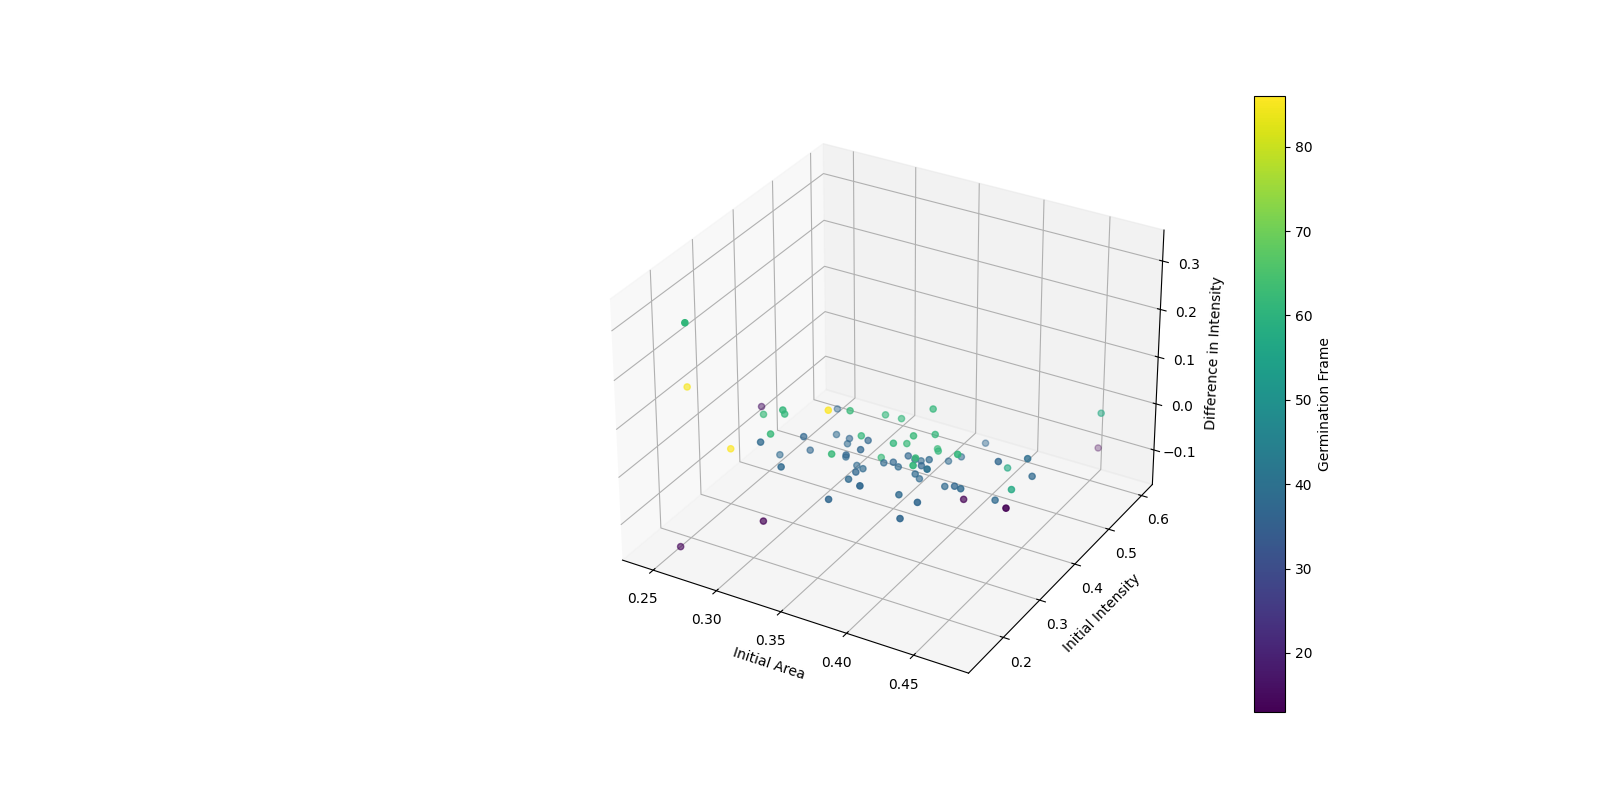

In [161]:
# INTENSITY x AREA
ax, analysis_data = scatter_3d_sizemetric(intensity_arrays, area_arrays, ["Intensity", "Area"])
#clustering_kmeans(ax, analysis_data, ["Intensity", "Area"])
#clustering_gmm(ax, analysis_data, ["Intensity", "Area"])
#clustering_dbscan(ax, analysis_data, ["Intensity", "Area"])

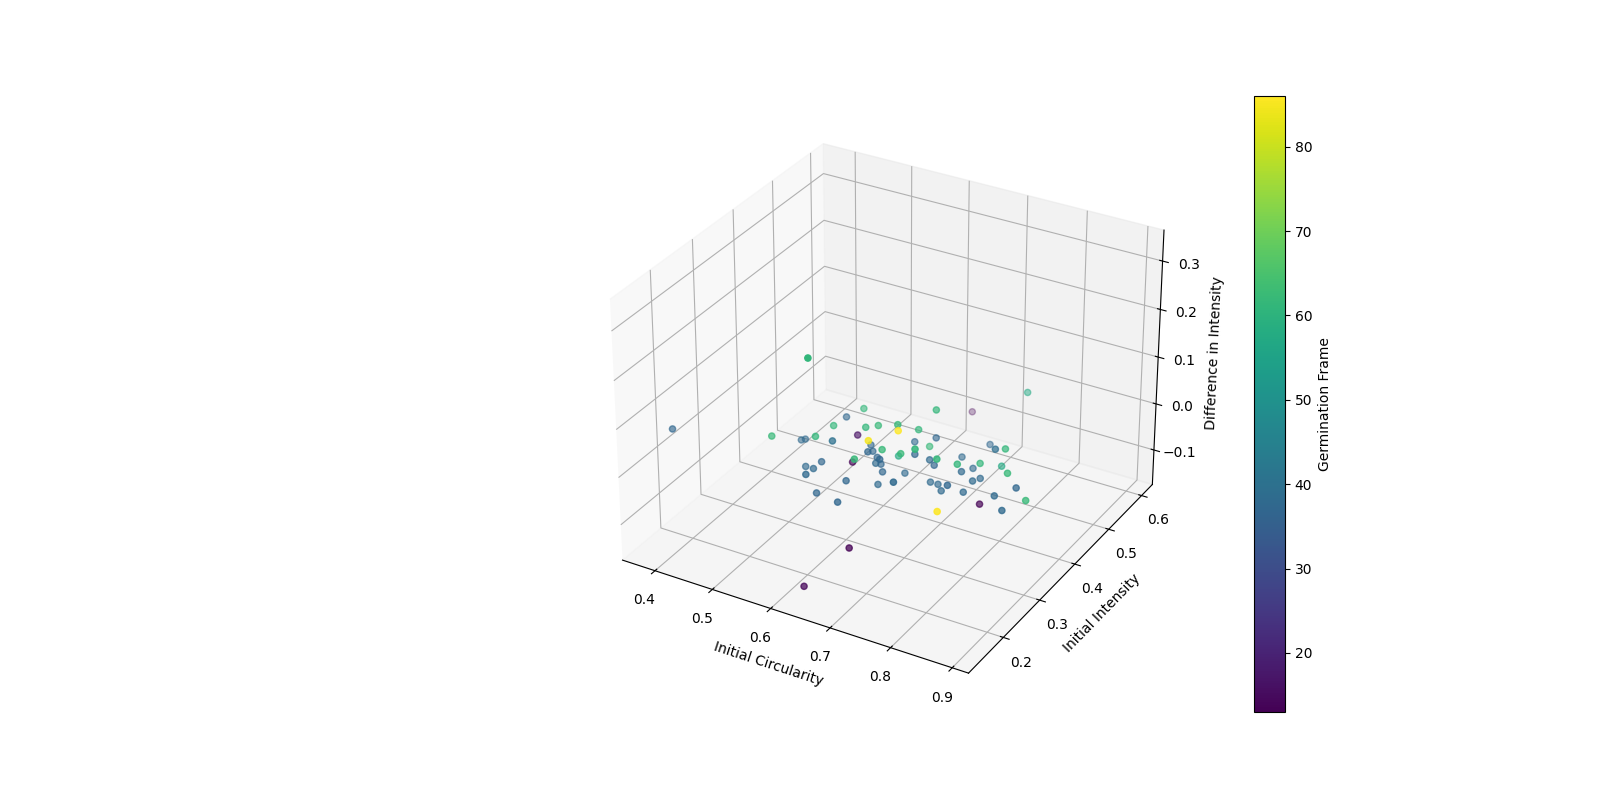

In [162]:
# INTENSITY X CIRCULARITY
ax, analysis_data = scatter_3d_sizemetric(intensity_arrays, circularity_arrays, ["Intensity", "Circularity"])
#clustering_kmeans(ax, analysis_data, ["Intensity", "Circularity"])
#clustering_gmm(ax, analysis_data, ["Intensity", "Circularity"])
#clustering_dbscan(ax, analysis_data, ["Intensity", "Circularity"])

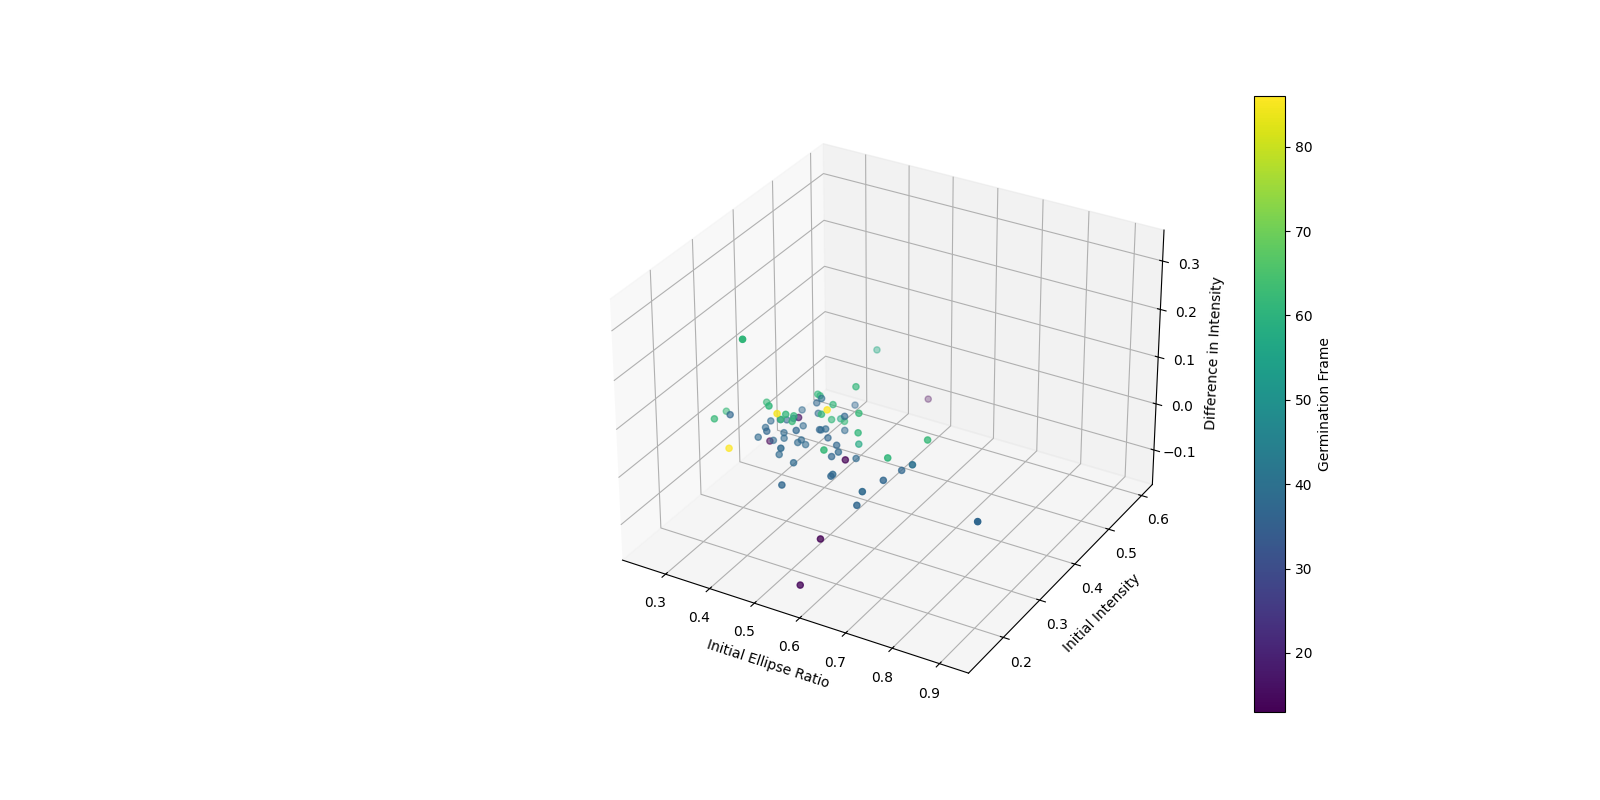

In [163]:
#INTENSITY X ELLIPSE RATIO
ax, analysis_data = scatter_3d_sizemetric(intensity_arrays, aspect_arrays, ["Intensity", "Ellipse Ratio"])
#clustering_kmeans(ax, analysis_data, ["Intensity", "Ellipse Ratio"])
#clustering_gmm(ax, analysis_data, ["Intensity", "Ellipse Ratio"])
#clustering_dbscan(ax, analysis_data, ["Intensity", "Ellipse Ratio"])

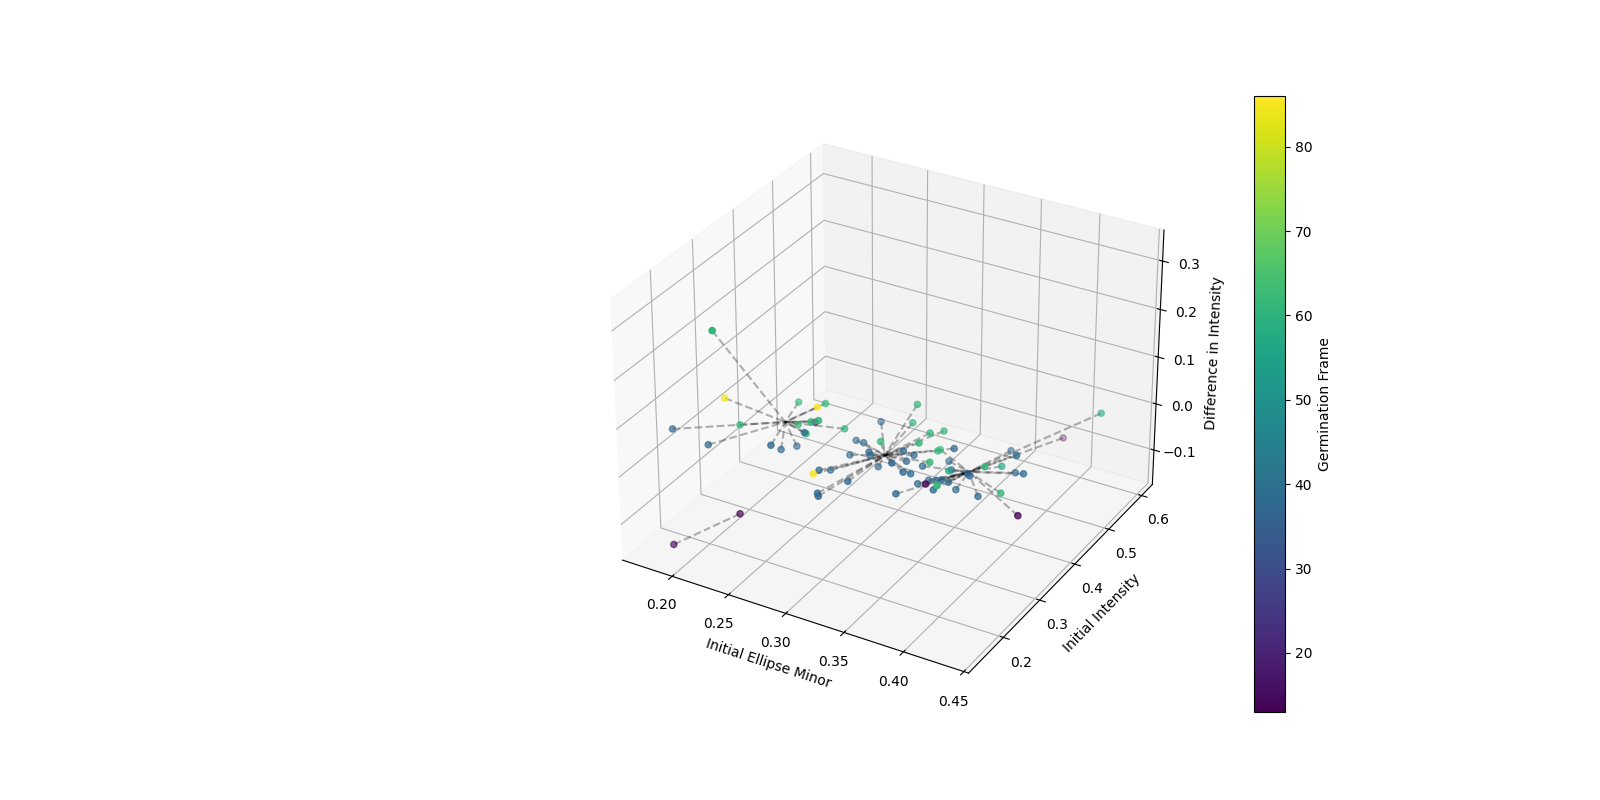

In [164]:
# INTENSITY X ELLIPSE MINOR
ax, analysis_data = scatter_3d_sizemetric(intensity_arrays, minor_arrays, ["Intensity", "Ellipse Minor"])
#clustering_kmeans(ax, analysis_data, ["Intensity", "Ellipse Minor"])
clustering_gmm(ax, analysis_data, ["Intensity", "Ellipse Minor"])
#clustering_dbscan(ax, analysis_data, ["Intensity", "Ellipse Minor"])

In [ ]:
def plot_elbow_method(scaled_data):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 8))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    plt.clf()
#plot_elbow_method(analysis_data)

## Signal Integration

In [ ]:
def sum_intensity(df, time_between_frames: int):
  '''summed intensity takes in GERMINATION and INTENSITY as pd.Series
  and sums intensity over time and plots each sum as a function of time
  '''
  df

  GERMINATION = df["GERMINATION"].apply(ast.literal_eval)
  INTENSITY = df["INTENSITY"].apply(ast.literal_eval)


  summed_intensity_allspores = []
  #iterate through spores
  for spore_index, spore_row in enumerate(INTENSITY):
    germination_frame = GERMINATION.apply(lambda x: x.index(1))
    summed_intensity: int = 0 

    #summed intensity at each timestep for each spore 
    summed_intensities: list[int] = []
    #iterate through intensity list of a given spore
    for intensity_index, intensity_value in enumerate(spore_row[0: int(germination_frame[spore_index])]):
      summed_intensity += intensity_value * time_between_frames
      summed_intensities.append(summed_intensity)
    summed_intensity_allspores.append(summed_intensities)
  
  sum_intensity_df = pd.DataFrame(summed_intensity_allspores)

  #plot 
  plt.xlabel("Frame")
  plt.ylabel("Integrated Electrochemical Potential")
  for row_index in range(len(sum_intensity_df)):
    row = list(sum_intensity_df.iloc[row_index, :])
    xs = range(len(row))
    sns.lineplot(x = xs, y = row)
  plt.savefig(f"{plots_folder}time_summation.jpg")
sum_intensity(df, time_between_frames)

## Spatial Dynamics

Plot values of the location within the image frame, with color denoting germination time

In [ ]:
def plot_xy_germinationframe(df):  
  '''
  plots x and y location with germination frame as z value 
  '''
  
  df['Germination Frame'] = df["GERMINATION"].apply(ast.literal_eval).apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  plt.figure(figsize=(6, 3))
  #plot
  scatter = plt.scatter(df['X_POSITION'], df['Y_POSITION'], c = df['Germination Frame'], cmap = 'gist_ncar', s=30)
  plt.colorbar(scatter, label='Germination Frame')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.gca().invert_yaxis()
  plt.title('Spores by Germination Frame')
  plt.grid(True)
  plt.savefig(f"{plots_folder}germinationframe_location.jpg")

  plt.clf()
  
if combined_dataset != 1:
  plot_xy_germinationframe(df)